In [1]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import RFE

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import IsolationForest

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures


import scipy


import pandas as pd
#import wandb

import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [2]:
def select_features(X, y, num_features):
    model = XGBRegressor(n_estimators=100, n_jobs=-1)
    #model = KNeighborsClassifier(n_neighbors=20)

    selector = RFE(estimator=model, n_features_to_select=num_features, step=20)
    #selector = SequentialFeatureSelector(model, n_features_to_select=num_features, n_jobs=10, cv=10)

    print('[INFO] fitting selector ...')
    selector.fit(X, y[:, 0])

    # discard unimportant features
    print('[INFO] transfroming X ...')
    X_new = selector.transform(X)
    print('[INFO] Done.')
    return X_new

def remove_outliers(X, y):
    iforst = IsolationForest(n_estimators=1000, n_jobs=-1, contamination='auto')
    #print('[INFO] fit transfrom outlier detection ...')
    outliers = iforst.fit_predict(X)
    mask = outliers != -1
    X_new = X[mask, :] 
    y_new = y[mask, :]
    #print('[INFO] Done.')
    return X_new, y_new, mask


def impute(X, y, k):
    imp = KNNImputer(n_neighbors=k)
    X_new = imp.fit_transform(X)
    return X_new, y.values

def get_score(X, y, model, scalerY):
    y_hat = model.predict(X).reshape( (len(X), 1) )
    y_hat = scalerY.inverse_transform(y_hat)

    y_true = y.reshape( (len(y), 1) )
    y_true = scalerY.inverse_transform(y_true)
    return r2_score( y_true, y_hat )
    

In [3]:
df_x = pd.read_csv('X_train.csv', index_col='id')

df_y = pd.read_csv('y_train.csv', index_col='id')

df_x['y'] = df_y.values
df_x.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x823,x824,x825,x826,x827,x828,x829,x830,x831,y
id,,,,,,,,,,,,,,,,,,,,,
0.0,10.891876,832442.812375,20585.544083,1028.369495,1.163780e+06,9.199135,597900.477629,NaN,1.144294e+06,785176.201298,...,-855.549602,12176.073427,10.647729,10.916371,1220.065443,8.566724,1.036263e+06,85338.558539,103088.664210,71.0
1.0,11.512994,832442.898114,NaN,1012.624877,1.028911e+06,10.906408,597900.458612,8127.016078,1.099166e+06,785176.258299,...,-787.397942,10493.095660,10.586492,9.463962,917.094909,10.231822,1.007163e+06,95695.020645,105161.109422,73.0
2.0,11.052185,832442.896307,20585.512844,1003.953827,9.231756e+05,9.212979,597900.426764,10738.092422,1.027863e+06,785176.223468,...,-906.997242,10959.516944,10.769287,10.342160,637.027802,10.705461,1.019955e+06,80253.299882,104177.051666,66.0
3.0,11.642076,NaN,NaN,1004.672084,9.459461e+05,9.553420,597900.450367,13524.096973,1.168144e+06,785176.254867,...,-1011.742516,16845.309819,10.483830,10.594941,1114.069590,10.321063,1.085442e+06,NaN,102746.516920,55.0
4.0,10.407121,832442.831424,20585.557007,NaN,9.957182e+05,8.419164,597900.423639,12894.065081,1.063199e+06,785176.190880,...,-1025.223865,18348.460040,NaN,NaN,1230.088215,10.250096,1.024812e+06,101815.745499,105163.749149,67.0


<AxesSubplot:>

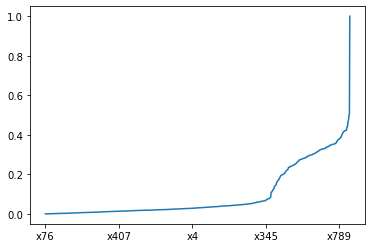

In [4]:
T = 0.1
corr = df_x.corrwith(df_x['y']).abs()
corr.sort_values().plot()

In [14]:
cross_val = KFold(n_splits=10, shuffle=True)
models = ['KRR']
best = 0

for T in [0.1]:
    for k in [60]:
        for alpha in [0.01]: #[0.2, 0.1, 0.05, 0.01]:
            for gamma in [0.005]:
                kernel = 'rbf'
                

                scores_test = [[] for _ in range(4)]
                df_x = pd.read_csv('X_train.csv', index_col='id')

                df_y = pd.read_csv('y_train.csv', index_col='id')

                df_x['y'] = df_y.values
                corr = df_x.corrwith(df_x['y']).abs()

                #T = 0.1
                cols = []
                for idx, co in zip(corr.index, corr.values):
                    if co >= T:
                        cols.append(idx)

                df_x = df_x[cols]
                df_y = df_x.pop('y')
                df_x = df_x.values

                
                X_imp, y_imp = impute(df_x, df_y, k)
                
                len_old = len(X_imp)
                #X_imp = pd.DataFrame(df_x).fillna(0).values
                X, y, mask = remove_outliers(X_imp, y_imp.reshape((len(y_imp), 1)))
                X_imp, y_imp = df_x[mask, :], df_y.values[mask]
                print(len_old - len(X_imp))

                for id_train, id_test in cross_val.split(X_imp):
                    X_train, y_train = np.array([X_imp[idx] for idx in id_train]), np.array([y_imp[idx] for idx in id_train])
                    X_test, y_test = np.array([X_imp[idx] for idx in id_test]), np.array([y_imp[idx] for idx in id_test])

                    y_train = y_train.reshape((len(y_train), 1))
                    y_test = y_test.reshape((len(y_test), 1))
                    
                    #X_train, _ = impute(X_train, pd.DataFrame(y_train), k)
                    #X_test, _ = impute(X_test, pd.DataFrame(y_test), k)

                    scalerX = StandardScaler().fit(X_train)
                    scalerY = StandardScaler().fit(y_train)

                    X_train = scalerX.transform(X_train)
                    X_test = scalerX.transform(X_test)

                    y_train = scalerY.transform(y_train)
                    y_test = scalerY.transform(y_test)

                    imp = KNNImputer(n_neighbors=k).fit(X_train)

                    X_train = imp.transform(X_train)
                    X_test = imp.transform(X_test)

                    if 'ETR' in models:
                        #model = ExtraTreesRegressor(n_jobs=-1, max_depth=None, n_estimators=1000, min_samples_split=2, min_samples_leaf=1, verbose=0) = 63
                        model = ExtraTreesRegressor(n_jobs=-1, max_depth=None, n_estimators=1000, min_samples_split=2, min_samples_leaf=1, verbose=0)
                        model.fit(X_train, y_train.ravel())
                        train_score = get_score(X_train, y_train, model, scalerY)
                        test_score = get_score(X_test, y_test, model, scalerY)
                        scores_test[0].append(test_score)
                        print('{:.3f}\t{:.3f}\tETR'.format(train_score, test_score))
                    else:
                        scores_test[0].append(0)
                    
                    if 'XGB' in models:
                        #model = XGBRegressor(n_estimators=1000, max_depth=None, eta=0.01, subsample=0.5, colsample_bytree=0.8, gamma=0.1) = 0.66
                        model = XGBRegressor(
                            n_estimators=1000, 
                            eta=0.01, 
                            gamma=0.1, 
                            max_depth=None, 
                            min_child_weight=1,
                            max_delta_step=0,
                            subsample=0.5,
                            colsample_bytree=0.8,
                            colsample_bylevel=1,
                            colsample_bynode=1,
                            reg_lambda=1,
                            tree_method='exact',
                            nthread=-1
                        )
                        
                        model.fit(X_train, y_train)
                        train_score = get_score(X_train, y_train, model, scalerY)
                        test_score = get_score(X_test, y_test, model, scalerY)
                        scores_test[1].append(test_score)

                        print('{:.3f}\t{:.3f}\tXGB'.format(train_score, test_score))
                    else:
                        scores_test[1].append(0)

                    if 'KRR' in models:
                        #model = KernelRidge(alpha=0.01, kernel='rbf', gamma=0.005) = 0.69
                        model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)
                        model.fit(X_train, y_train)
                        train_score = get_score(X_train, y_train, model, scalerY)
                        test_score = get_score(X_test, y_test, model, scalerY)
                        scores_test[2].append(test_score)
                        
                        #print('{:.3f}\t{:.3f}\tKRR'.format(train_score, test_score))
                    else:
                        scores_test[2].append(0)
                    
                    if 'GBR' in models:
                        model = GradientBoostingRegressor(n_estimators=1000, n_iter_no_change=10)
                        model.fit(X_train, y_train.ravel())
                        train_score = get_score(X_train, y_train, model, scalerY)
                        test_score = get_score(X_test, y_test, model, scalerY)
                        scores_test[3].append(test_score)
                        print('{:.3f}\t{:.3f}\tGBR'.format(train_score, test_score))
                    else:
                        scores_test[3].append(0)

                    #print()
                    
                print(f'Test score for T: {T}, , k: {60}, a: {alpha}, gamma: {gamma}')
                #print("score: {:.3f} ({:.3f})".format(np.mean(scores_test[2]), np.std(scores_test[2]))) 
                #best = max(best, np.mean(scores_test[2]))
                #print("Best: {:.3f}".format(best))
                #print()
                m = ['ETR', 'XGB', 'KRR', 'GBR']
                #best = max(best, np.mean(scores_test[2]))
                for i in range(4):
                    print("{}: {:.3f} ({:.3f}), best: {}".format(m[i], np.mean(scores_test[i]), np.std(scores_test[i]), best))

71
Test score for T: 0.1, , k: 60, a: 0.01, gamma: 0.005
ETR: 0.000 (0.000), best: 0
XGB: 0.000 (0.000), best: 0
KRR: 0.700 (0.045), best: 0
GBR: 0.000 (0.000), best: 0


# Predict test set

In [15]:
# Parameters
k = 60
alpha = 0.01
gamma = 0.005
kernel = 'rbf'

# Load data
df_x = pd.read_csv('X_train.csv', index_col='id')

df_y = pd.read_csv('y_train.csv', index_col='id')

# Load test set
df_test = pd.read_csv('X_test.csv', index_col='id')
df_test = df_test[[x for x in cols if x != 'y']]

df_x['y'] = df_y.values

# Calculate correlation
T = 0.1
corr = df_x.corrwith(df_x['y']).abs()

# Remove unimportant features
cols = []
for idx, co in zip(corr.index, corr.values):
    if co >= T:
        cols.append(idx)

df_x = df_x[cols]
df_y = df_x.pop('y')
df_x = df_x.values

#print(df_x.shape)

# Impute data
X_imp = KNNImputer(n_neighbors=k).fit_transform(df_x)
y_imp = df_y.values
                
X, y, mask = remove_outliers(X_imp, y_imp.reshape((len(y_imp), 1)))
X_imp, y_imp = df_x[mask, :], df_y.values[mask]


# Create training set
X_train, y_train = np.array(X_imp), np.array(y_imp).reshape((len(y_imp), 1))
#print(y_train.shape)

scalerX = StandardScaler().fit(X_train)
scalerY = StandardScaler().fit(y_train)
X_train = scalerX.transform(X_train)
y_train = scalerY.transform(y_train)

imp = KNNImputer(n_neighbors=k).fit(X_train)
X_train = imp.transform(X_train)

# Remove outliers
#remove_outliers(X_train, y_train)

# Fit Model
model = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
model.fit(X_train, y_train)
train_score = get_score(X_train, y_train, model, scalerY)

# Load test set
df_test = pd.read_csv('X_test.csv', index_col='id')
df_test = df_test[[x for x in cols if x != 'y']]

# Impute
X_test = scalerX.transform(df_test)
X_test = imp.transform(X_test)


# Predict
y_hat = model.predict(X_test)
#print(y_hat[:, 0])
y_hat = scalerY.inverse_transform(y_hat)
print(y_hat[:, 0])
pd.DataFrame({'id': df_test.index, 'y': y_hat[:,0]}).set_index('id').to_csv('y_hat.csv')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[69.79042381 75.10647671 70.07894731 72.4588414  68.10130379 75.22251949
 61.36194571 58.71480583 83.6255523  75.65372272 58.45850399 83.90436129
 72.61974031 78.53910276 56.93878939 86.63282787 70.85500889 77.114419
 70.05174788 70.70640021 69.14389818 62.04770923 80.52563702 75.32623814
 59.86820512 72.92735135 55.99219275 75.40977441 61.82217315 73.18980001
 66.1890324  70.86345728 58.38744498 73.89766795 65.8712363  64.42545765
 76.71796497 51.34043944 71.47331803 68.30486471 65.65543203 76.06391831
 71.25626334 75.62175956 74.46903255 69.3561175  71.36262989 74.74501944
 72.43827024 68.41088796 78.1469086  64.69400574 62.25705126 83.18216116
 82.26433    69.19474162 67.47123663 69.45699059 71.20567147 58.61467671
 60.49796615 74.2485915  62.51524682 72.67169041 72.61608143 56.39417263
 68.28621182 77.05837157 64.06791134 73.16204328 58.60776843 76.2742983
 68.34772854 60.21947616 65.91073976 72.76665491 75.41029363 60.70223339
 79.74289592 82.86641327 77.27103113 79.7614512  68.43